# Lab 4, Day 1: Theory Activities — From Linear Models to MLPs
## COMP 395 – Deep Learning

**Companion notebook for the Day 1 lecture slides.**

This notebook contains:
1. **Activity 1:** Two linear layers collapse to one (code demo)
2. **Activity 2:** Activation function exploration (sigmoid vs ReLU)
3. **Activity 3:** BCE vs MSE loss comparison
4. **Activity 4:** Pen-and-paper backpropagation exercise


---
## Setup


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 12


---
## Activity 1: Two Linear Layers Collapse to One

The slides claimed that stacking two linear layers (without activation) is equivalent to a single linear layer. Let's verify this empirically.

### Part A: Create two linear layers and compose them


In [2]:
# Two separate linear layers (no activation between them)
torch.manual_seed(42)
layer1 = nn.Linear(3, 4)   # 3 inputs -> 4 outputs
layer2 = nn.Linear(4, 2)   # 4 inputs -> 2 outputs

# Compose them: layer2(layer1(x))
x = torch.randn(1, 3)
h = layer1(x)          # intermediate
y_two = layer2(h)       # final output from two layers

print(f"Input:  {x}")
print(f"Hidden: {h}")
print(f"Output: {y_two}")


Input:  tensor([[ 0.6688, -0.7077, -0.3267]])
Hidden: tensor([[ 0.4268,  0.4844, -0.3158, -0.7552]], grad_fn=<AddmmBackward0>)
Output: tensor([[-0.2169, -0.5436]], grad_fn=<AddmmBackward0>)


### Part B: Collapse into a single equivalent layer

If $\mathbf{y} = W_2(W_1\mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2 = (W_2 W_1)\mathbf{x} + (W_2\mathbf{b}_1 + \mathbf{b}_2)$

then we can create one layer with $W' = W_2 W_1$ and $\mathbf{b}' = W_2\mathbf{b}_1 + \mathbf{b}_2$.


In [3]:
# Compute the equivalent single-layer weights
W1, b1 = layer1.weight.data, layer1.bias.data
W2, b2 = layer2.weight.data, layer2.bias.data

W_combined = W2 @ W1                    # matrix multiply
b_combined = W2 @ b1 + b2               # combined bias

# Create a single layer with these weights
single_layer = nn.Linear(3, 2)
single_layer.weight.data = W_combined
single_layer.bias.data = b_combined

# Compare outputs
y_single = single_layer(x)

print(f"Two layers output:    {y_two.detach()}")
print(f"Single layer output:  {y_single.detach()}")
print(f"Difference:           {(y_two - y_single).abs().max().item():.2e}")


Two layers output:    tensor([[-0.2169, -0.5436]])
Single layer output:  tensor([[-0.2169, -0.5436]])
Difference:           0.00e+00


### ✏️ Reflection
**Think-Pair-Share:** 
- The two approaches give (essentially) the same output. What does this tell us about the *representational power* of stacking linear layers?
- If depth with linear layers doesn't help, what *does* adding depth buy us when we include nonlinear activations?


---
## Activity 2: Activation Functions — Sigmoid vs ReLU

Let's visualize both functions and their derivatives to understand *why* ReLU is preferred for hidden layers.


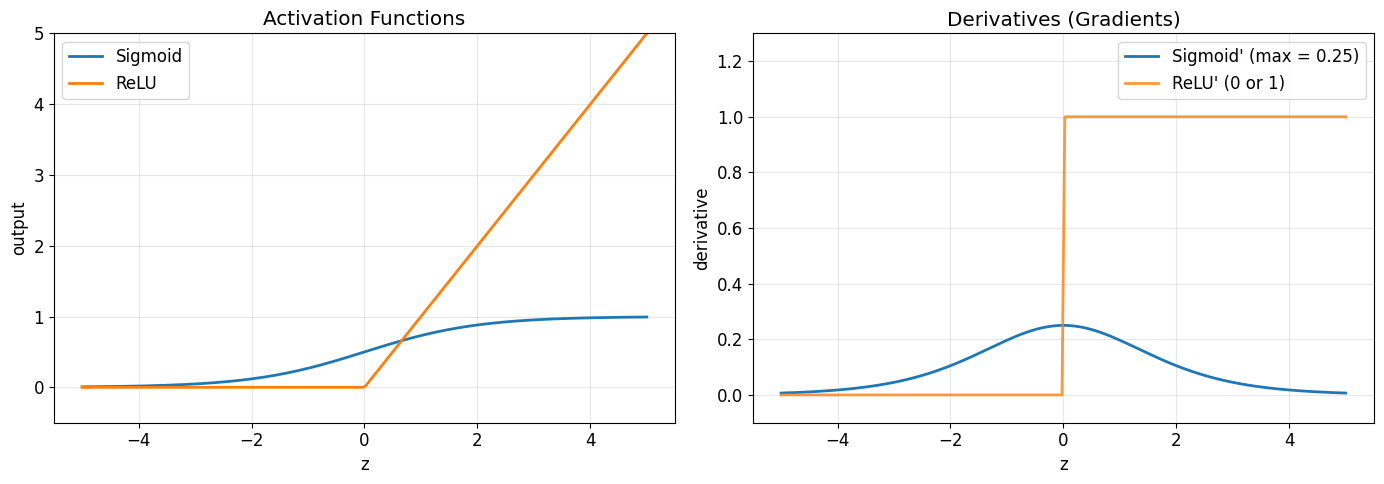

In [4]:
z = torch.linspace(-5, 5, 200)

# Sigmoid
sigmoid_out = torch.sigmoid(z)
sigmoid_grad = sigmoid_out * (1 - sigmoid_out)

# ReLU
relu_out = torch.relu(z)
relu_grad = (z > 0).float()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: the functions themselves
axes[0].plot(z.numpy(), sigmoid_out.numpy(), label='Sigmoid', linewidth=2)
axes[0].plot(z.numpy(), relu_out.numpy(), label='ReLU', linewidth=2)
axes[0].set_title('Activation Functions')
axes[0].set_xlabel('z')
axes[0].set_ylabel('output')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.5, 5)

# Right: their derivatives
axes[1].plot(z.numpy(), sigmoid_grad.numpy(), label="Sigmoid' (max = 0.25)", linewidth=2)
axes[1].plot(z.numpy(), relu_grad.numpy(), label="ReLU' (0 or 1)", linewidth=2, alpha=0.8)
axes[1].set_title('Derivatives (Gradients)')
axes[1].set_xlabel('z')
axes[1].set_ylabel('derivative')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-0.1, 1.3)

plt.tight_layout()
plt.show()


### The Vanishing Gradient Problem

Let's see what happens when we chain sigmoid derivatives through multiple layers:


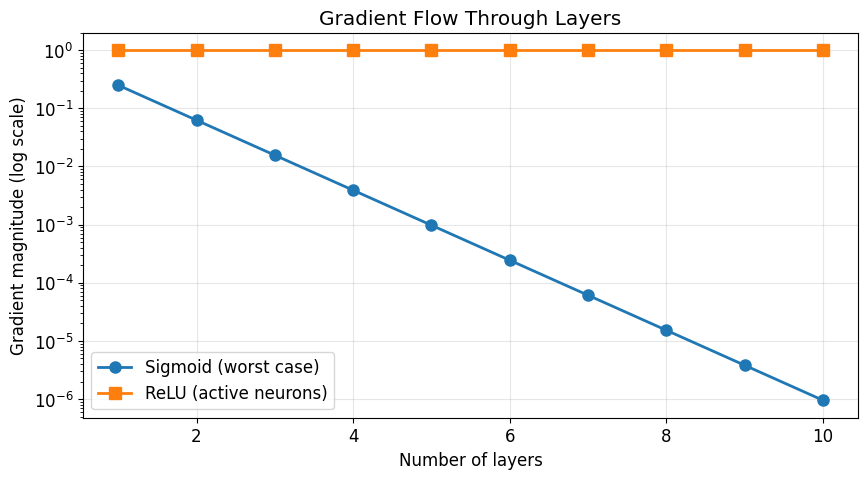

After 5 sigmoid layers: gradient ~ 0.000977
After 10 sigmoid layers: gradient ~ 0.0000009537


In [5]:
# Simulate gradient flow through N layers of sigmoid vs ReLU
n_layers = range(1, 11)
# For sigmoid: max gradient at each layer is 0.25
sigmoid_gradient_flow = [0.25**n for n in n_layers]
# For ReLU: gradient is 1 (when active)
relu_gradient_flow = [1.0**n for n in n_layers]

plt.figure(figsize=(10, 5))
plt.plot(list(n_layers), sigmoid_gradient_flow, 'o-', label='Sigmoid (worst case)', linewidth=2, markersize=8)
plt.plot(list(n_layers), relu_gradient_flow, 's-', label='ReLU (active neurons)', linewidth=2, markersize=8)
plt.yscale('log')
plt.xlabel('Number of layers')
plt.ylabel('Gradient magnitude (log scale)')
plt.title('Gradient Flow Through Layers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"After 5 sigmoid layers: gradient ~ {0.25**5:.6f}")
print(f"After 10 sigmoid layers: gradient ~ {0.25**10:.10f}")


### ✏️ Reflection
**Think-Pair-Share:**
- Why does the sigmoid gradient shrink so dramatically with depth?
- ReLU has gradient = 0 when z ≤ 0 (the neuron is "dead"). Is this a problem? When might it happen?
- If ReLU can "kill" neurons, why is it still preferred over sigmoid for hidden layers?


---
## Activity 3: BCE vs MSE Loss

Let's compare how the two loss functions behave for binary classification.


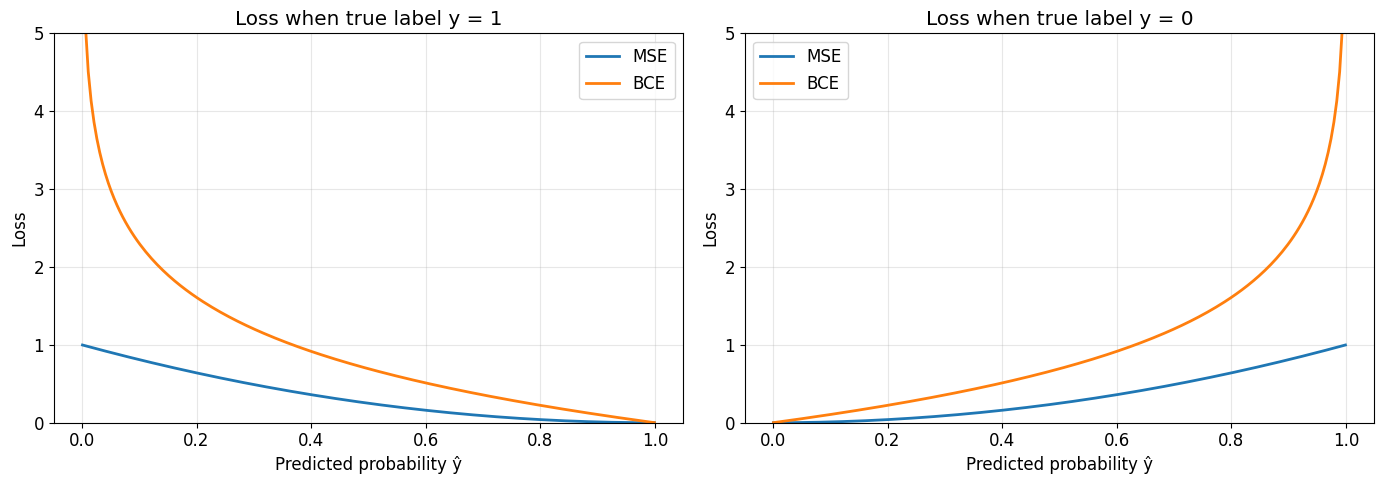

In [6]:
y_hat = torch.linspace(0.001, 0.999, 200)  # predicted probabilities

# When true label is y=1
mse_loss_y1 = (y_hat - 1)**2
bce_loss_y1 = -torch.log(y_hat)

# When true label is y=0
mse_loss_y0 = (y_hat - 0)**2
bce_loss_y0 = -torch.log(1 - y_hat)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# y = 1
axes[0].plot(y_hat.numpy(), mse_loss_y1.numpy(), label='MSE', linewidth=2)
axes[0].plot(y_hat.numpy(), bce_loss_y1.numpy(), label='BCE', linewidth=2)
axes[0].set_title('Loss when true label y = 1')
axes[0].set_xlabel('Predicted probability ŷ')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 5)

# y = 0
axes[1].plot(y_hat.numpy(), mse_loss_y0.numpy(), label='MSE', linewidth=2)
axes[1].plot(y_hat.numpy(), bce_loss_y0.numpy(), label='BCE', linewidth=2)
axes[1].set_title('Loss when true label y = 0')
axes[1].set_xlabel('Predicted probability ŷ')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 5)

plt.tight_layout()
plt.show()


### ✏️ Reflection
**Think-Pair-Share:**
- Look at the left plot: when the model predicts ŷ = 0.01 but y = 1, which loss is larger? By how much?
- Which loss function has a steeper slope (bigger gradient) for very wrong predictions?
- Why does this matter for training? Think about what happens in the first few epochs when the model hasn't learned much yet.


---## Activity 4: Pen-and-Paper BackpropagationWork through this exercise by hand (pen and paper or tablet). You may use the code cells below to check your work.### The NetworkA tiny network with 2 inputs, 2 hidden neurons (ReLU), and 1 output (sigmoid):$$h_1 = \text{ReLU}(w_{11} x_1 + w_{12} x_2 + b_1^{(1)})$$$$h_2 = \text{ReLU}(w_{21} x_1 + w_{22} x_2 + b_2^{(1)})$$$$\hat{y} = \sigma(v_1 h_1 + v_2 h_2 + b^{(2)})$$

> **Notation note:** We use $w_{ij}$ for the **hidden layer** weights (layer 1) and $v_j$ for the **output layer** weights (layer 2). The different letter makes it easy to tell which layer a weight belongs to at a glance — $w$ connects inputs to hidden neurons, $v$ connects hidden neurons to the output.### Given Values| Parameter | Value ||-----------|-------|| $w_{11}$  | 0.5   || $w_{12}$  | -0.3  || $w_{21}$  | 0.8   || $w_{22}$  | 0.2   || $b_1^{(1)}$ | 0.1 || $b_2^{(1)}$ | -0.1 || $v_1$     | 0.6   || $v_2$     | -0.4  || $b^{(2)}$ | 0.2   |**Training sample:** $\mathbf{x} = [1, 2]$, $y = 1$**Learning rate:** $\eta = 0.1$**Loss:** BCE = $-[y\log(\hat{y}) + (1-y)\log(1-\hat{y})]$

### Part A: Forward Pass

Compute each value step by step:

1. $z_1^{(1)} = w_{11} x_1 + w_{12} x_2 + b_1^{(1)} = $ ____
2. $h_1 = \text{ReLU}(z_1^{(1)}) = $ ____
3. $z_2^{(1)} = w_{21} x_1 + w_{22} x_2 + b_2^{(1)} = $ ____
4. $h_2 = \text{ReLU}(z_2^{(1)}) = $ ____
5. $z^{(2)} = v_1 h_1 + v_2 h_2 + b^{(2)} = $ ____
6. $\hat{y} = \sigma(z^{(2)}) = $ ____
7. $\mathcal{L} = $ ____


### Check your forward pass:

In [7]:
# Check your forward pass answers here
import math

x1, x2 = 1.0, 2.0
y = 1.0

w11, w12 = 0.5, -0.3
w21, w22 = 0.8, 0.2
b1_1, b2_1 = 0.1, -0.1
v1, v2 = 0.6, -0.4
b_2 = 0.2

# Forward pass
z1_1 = w11*x1 + w12*x2 + b1_1
h1 = max(0, z1_1)

z2_1 = w21*x1 + w22*x2 + b2_1
h2 = max(0, z2_1)

z_2 = v1*h1 + v2*h2 + b_2
y_hat = 1 / (1 + math.exp(-z_2))

loss = -(y * math.log(y_hat) + (1-y) * math.log(1-y_hat))

print(f"z1^(1) = {z1_1}")
print(f"h1     = {h1}")
print(f"z2^(1) = {z2_1}")
print(f"h2     = {h2}")
print(f"z^(2)  = {z_2}")
print(f"y_hat  = {y_hat:.6f}")
print(f"Loss   = {loss:.6f}")


z1^(1) = 2.7755575615628914e-17
h1     = 2.7755575615628914e-17
z2^(1) = 1.1
h2     = 1.1
z^(2)  = -0.24000000000000005
y_hat  = 0.440286
Loss   = 0.820330


### Part B: Backward Pass

Now compute the gradients, starting from the loss:

**Step 1:** Output layer gradient (BCE + sigmoid simplification):
$$\frac{\partial \mathcal{L}}{\partial z^{(2)}} = \hat{y} - y = $$ ____

**Step 2:** Gradients for output weights:
$$\frac{\partial \mathcal{L}}{\partial v_1} = \frac{\partial \mathcal{L}}{\partial z^{(2)}} \cdot h_1 = $$ ____

$$\frac{\partial \mathcal{L}}{\partial v_2} = \frac{\partial \mathcal{L}}{\partial z^{(2)}} \cdot h_2 = $$ ____

$$\frac{\partial \mathcal{L}}{\partial b^{(2)}} = \frac{\partial \mathcal{L}}{\partial z^{(2)}} = $$ ____

**Step 3:** Propagate to hidden layer:
$$\frac{\partial \mathcal{L}}{\partial h_1} = \frac{\partial \mathcal{L}}{\partial z^{(2)}} \cdot v_1 = $$ ____

$$\frac{\partial \mathcal{L}}{\partial h_2} = \frac{\partial \mathcal{L}}{\partial z^{(2)}} \cdot v_2 = $$ ____

**Step 4:** Through ReLU:
$$\frac{\partial \mathcal{L}}{\partial z_1^{(1)}} = \frac{\partial \mathcal{L}}{\partial h_1} \cdot \text{ReLU}'(z_1^{(1)}) = $$ ____

$$\frac{\partial \mathcal{L}}{\partial z_2^{(1)}} = \frac{\partial \mathcal{L}}{\partial h_2} \cdot \text{ReLU}'(z_2^{(1)}) = $$ ____

**Step 5:** Gradients for hidden weights:
$$\frac{\partial \mathcal{L}}{\partial w_{11}} = \frac{\partial \mathcal{L}}{\partial z_1^{(1)}} \cdot x_1 = $$ ____

$$\frac{\partial \mathcal{L}}{\partial w_{12}} = \frac{\partial \mathcal{L}}{\partial z_1^{(1)}} \cdot x_2 = $$ ____

(Compute the rest for $w_{21}, w_{22}, b_1^{(1)}, b_2^{(1)}$ as well.)


### Check your backward pass:

In [8]:
# Check your backward pass answers here
dL_dz2 = y_hat - y
print(f"dL/dz^(2) = {dL_dz2:.6f}")

dL_dv1 = dL_dz2 * h1
dL_dv2 = dL_dz2 * h2
dL_db2 = dL_dz2
print(f"dL/dv1    = {dL_dv1:.6f}")
print(f"dL/dv2    = {dL_dv2:.6f}")
print(f"dL/db^(2) = {dL_db2:.6f}")

dL_dh1 = dL_dz2 * v1
dL_dh2 = dL_dz2 * v2
print(f"dL/dh1    = {dL_dh1:.6f}")
print(f"dL/dh2    = {dL_dh2:.6f}")

relu_prime_z1 = 1.0 if z1_1 > 0 else 0.0
relu_prime_z2 = 1.0 if z2_1 > 0 else 0.0
dL_dz1_1 = dL_dh1 * relu_prime_z1
dL_dz2_1 = dL_dh2 * relu_prime_z2
print(f"dL/dz1^(1) = {dL_dz1_1:.6f}  (ReLU' = {relu_prime_z1})")
print(f"dL/dz2^(1) = {dL_dz2_1:.6f}  (ReLU' = {relu_prime_z2})")

dL_dw11 = dL_dz1_1 * x1
dL_dw12 = dL_dz1_1 * x2
dL_dw21 = dL_dz2_1 * x1
dL_dw22 = dL_dz2_1 * x2
dL_db1_1 = dL_dz1_1
dL_db2_1 = dL_dz2_1
print(f"\ndL/dw11   = {dL_dw11:.6f}")
print(f"dL/dw12   = {dL_dw12:.6f}")
print(f"dL/dw21   = {dL_dw21:.6f}")
print(f"dL/dw22   = {dL_dw22:.6f}")
print(f"dL/db1^(1) = {dL_db1_1:.6f}")
print(f"dL/db2^(1) = {dL_db2_1:.6f}")


dL/dz^(2) = -0.559714
dL/dv1    = -0.000000
dL/dv2    = -0.615685
dL/db^(2) = -0.559714
dL/dh1    = -0.335828
dL/dh2    = 0.223885
dL/dz1^(1) = -0.335828  (ReLU' = 1.0)
dL/dz2^(1) = 0.223885  (ReLU' = 1.0)

dL/dw11   = -0.335828
dL/dw12   = -0.671656
dL/dw21   = 0.223885
dL/dw22   = 0.447771
dL/db1^(1) = -0.335828
dL/db2^(1) = 0.223885


### Part C: Weight Update

Apply one step of gradient descent with $\eta = 0.1$:

$$w_{\text{new}} = w_{\text{old}} - \eta \cdot \frac{\partial \mathcal{L}}{\partial w}$$

Compute the updated values for all 9 parameters.


In [9]:
# Check your weight updates
eta = 0.1

print("Parameter updates (w_new = w_old - eta * gradient):")
print(f"w11: {w11:.4f} -> {w11 - eta*dL_dw11:.6f}")
print(f"w12: {w12:.4f} -> {w12 - eta*dL_dw12:.6f}")
print(f"w21: {w21:.4f} -> {w21 - eta*dL_dw21:.6f}")
print(f"w22: {w22:.4f} -> {w22 - eta*dL_dw22:.6f}")
print(f"b1^(1): {b1_1:.4f} -> {b1_1 - eta*dL_db1_1:.6f}")
print(f"b2^(1): {b2_1:.4f} -> {b2_1 - eta*dL_db2_1:.6f}")
print(f"v1:  {v1:.4f} -> {v1 - eta*dL_dv1:.6f}")
print(f"v2:  {v2:.4f} -> {v2 - eta*dL_dv2:.6f}")
print(f"b^(2): {b_2:.4f} -> {b_2 - eta*dL_db2:.6f}")


Parameter updates (w_new = w_old - eta * gradient):
w11: 0.5000 -> 0.533583
w12: -0.3000 -> -0.232834
w21: 0.8000 -> 0.777611
w22: 0.2000 -> 0.155223
b1^(1): 0.1000 -> 0.133583
b2^(1): -0.1000 -> -0.122389
v1:  0.6000 -> 0.600000
v2:  -0.4000 -> -0.338431
b^(2): 0.2000 -> 0.255971


### Part D: Verify with PyTorch Autograd

Let's verify our hand-computed gradients match what PyTorch computes:


In [10]:
# Verify with PyTorch autograd
x = torch.tensor([[1.0, 2.0]])
y_true = torch.tensor([[1.0]])

# Recreate network with same weights
W1 = torch.tensor([[0.5, -0.3],
                    [0.8,  0.2]], requires_grad=True)
b1 = torch.tensor([[0.1, -0.1]], requires_grad=True)
V  = torch.tensor([[0.6, -0.4]], requires_grad=True)
b2_t = torch.tensor([[0.2]], requires_grad=True)

# Forward pass
z1 = x @ W1.T + b1
h  = torch.relu(z1)
z2 = h @ V.T + b2_t
y_pred = torch.sigmoid(z2)

# BCE loss
loss = nn.BCELoss()(y_pred, y_true)

# Backward pass
loss.backward()

print("PyTorch autograd gradients:")
print(f"W1.grad = {W1.grad}")
print(f"b1.grad = {b1.grad}")
print(f"V.grad  = {V.grad}")
print(f"b2.grad = {b2_t.grad}")
print(f"\nDo they match your hand computations?")


PyTorch autograd gradients:
W1.grad = tensor([[0.0000, 0.0000],
        [0.2239, 0.4478]])
b1.grad = tensor([[0.0000, 0.2239]])
V.grad  = tensor([[ 0.0000, -0.6157]])
b2.grad = tensor([[-0.5597]])

Do they match your hand computations?


### ✏️ Final Reflection

**Think-Pair-Share:**
1. Did your hand-computed gradients match PyTorch's? If not, where did you go wrong?
2. What was the most mechanically difficult part of the backprop computation?
3. Now imagine doing this for a network with 60 inputs and multiple hidden layers with dozens of neurons each. How many individual gradient computations would that require? Why is autograd essential?

---
**Tomorrow:** We implement a linear model in PyTorch on the Sonar dataset, then you'll **design your own MLP architecture** and run experiments to find what works best. Come prepared with ideas about how deep and how wide your network should be!
